# Linear Regression using Philippine Standard DHS

Can we build a linear model to predict total births of a woman using other known characteristics related to her health & their household as features?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Let's load & inspect the data

To save us time in recoding the different datasets, we can use the recoded SPSS files provided by DHS. To read the data, we need to use a **pyreadstat** python package instead of pandas. 

The code for loading the data and its dictionaries are prepared below.

In [2]:
import pyreadstat

df, meta = pyreadstat.read_sav('data/PHIR71FL.SAV')
df.head()

,CASEID,V000,V001,V002,V003,V004,V005,V006,V007,V008,...,SPREGOUT$11,SPREGOUT$12,SPREGOUT$13,SPREGOUT$14,SPREGOUT$15,SPREGOUT$16,SPREGOUT$17,SPREGOUT$18,SPREGOUT$19,SPREGOUT$20
0,00010001 2,PH7,1.0,1.0,2.0,1.0,361799.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00010001 7,PH7,1.0,1.0,7.0,1.0,361799.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00010002 4,PH7,1.0,2.0,4.0,1.0,361799.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00010004 2,PH7,1.0,4.0,2.0,1.0,361799.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00010007 2,PH7,1.0,7.0,2.0,1.0,361799.0,8.0,2017.0,1412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
meta.column_names_to_labels

{'CASEID': 'Case Identification',
 'V000': 'Country code and phase',
 'V001': 'Cluster number',
 'V002': 'Household number',
 'V003': "Respondent's line number",
 'V004': 'Ultimate area unit',
 'V005': "Women's individual sample weight (6 decimals)",
 'V006': 'Month of interview',
 'V007': 'Year of interview',
 'V008': 'Date of interview (CMC)',
 'V008A': 'Date of interview Century Day Code (CDC)',
 'V009': "Respondent's month of birth",
 'V010': "Respondent's year of birth",
 'V011': 'Date of birth (CMC)',
 'V012': "Respondent's current age",
 'V013': 'Age in 5-year groups',
 'V014': 'Completeness of age information',
 'V015': 'Result of individual interview',
 'V016': 'Day of interview',
 'V017': 'NA - CMC start of calendar',
 'V018': 'Row of month of interview',
 'V019': 'Length of calendar',
 'V019A': 'Number of calendar columns',
 'V020': 'Ever-married sample',
 'V021': 'Primary sampling unit',
 'V022': 'Sample strata for sampling errors',
 'V024': 'Region',
 'V025': 'Type of plac

In [4]:
meta.variable_value_labels

{'V013': {1.0: '15-19',
  2.0: '20-24',
  3.0: '25-29',
  4.0: '30-34',
  5.0: '35-39',
  6.0: '40-44',
  7.0: '45-49'},
 'V014': {1.0: 'Month and year - information complete',
  2.0: 'Month and age - year imputed',
  3.0: 'Year and age - month imputed',
  4.0: 'Year and age - year ignored',
  5.0: 'Year - age/month imputed',
  6.0: 'Age - year/month imputed',
  7.0: 'Month - age/year imputed',
  8.0: 'None - all imputed'},
 'V015': {1.0: 'Completed',
  2.0: 'Not at home',
  3.0: 'Postponed',
  4.0: 'Refused',
  5.0: 'Partially completed',
  6.0: 'Respondent incapacitated',
  7.0: 'OCW/OFW',
  8.0: 'Other'},
 'V018': {0.0: 'No calendar'},
 'V019': {0.0: 'No calendar'},
 'V019A': {0.0: 'No calendar'},
 'V020': {0.0: 'All woman sample', 1.0: 'Ever married sample'},
 'V022': {1.0: 'BASILAN',
  2.0: 'CITY OF ISABELA',
  3.0: 'LANAO DEL SUR',
  4.0: 'MAGUINDANAO',
  5.0: 'COTABATO CITY',
  6.0: 'SULU',
  7.0: 'TAWI-TAWI',
  8.0: 'ABRA',
  9.0: 'APAYAO',
  10.0: 'BAGUIO CITY',
  11.0: 'BENGU

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25074 entries, 0 to 25073
Columns: 5731 entries, CASEID to SPREGOUT$20
dtypes: float64(5729), object(2)
memory usage: 1.1+ GB


In [6]:
# Filtering columns from the dataset
# Columns specific to births are only removed for the sake of streamlining columns to choose from 
df.dropna(axis = 1, how = 'all', inplace = True)
df = df.loc[:,~df.columns.str.contains('\$')]

df.shape

(25074, 494)

In [7]:
# V201: Total children ever born
# V212: Age of respondent at 1st birth
# V316: Year of start of use of method
# V384A: Heard family planning on radio last few months
# V384B: Heard family planning on TV last few months
# V384C: Heard family planning in newspaper/magazine last few months
# V384D: Heard family planning by text messages on mobile phone
# V512: Years since first cohabitation
# V531: Age at first sex (imputed)
# V613: Ideal number of children
# V730: Husband/partner's age
# V715: Husband/partner's total number of years of education
# V732: Respondent employed all year/seasonal
# V133: Education in single years
# V704A: Husband/partner worked in last 7 days/12 months

# Filter to select columns
df =df[['V201','V212','V316','V384A','V384B','V384C','V384D',
        'V512','V531','V613','V730','V715', 'V732','V133','V704A']]

df.head()

,V201,V212,V316,V384A,V384B,V384C,V384D,V512,V531,V613,V730,V715,V732,V133,V704A
0,4.0,21.0,2015.0,0.0,1.0,0.0,1.0,10.0,19.0,6.0,34.0,15.0,1.0,14.0,1.0
1,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,NaN,3.0,0.0,NaN
2,1.0,29.0,NaN,1.0,1.0,1.0,0.0,7.0,26.0,3.0,33.0,15.0,1.0,15.0,1.0
3,2.0,21.0,NaN,1.0,1.0,1.0,0.0,32.0,14.0,3.0,37.0,11.0,1.0,7.0,1.0
4,3.0,23.0,2017.0,0.0,0.0,0.0,0.0,9.0,21.0,2.0,27.0,9.0,NaN,8.0,1.0


In [8]:
# Inspecting expected values of selected columns
for col in df.columns:
    print(f'{col}: {meta.column_names_to_labels[col]}')
    try:
        print(meta.variable_value_labels[col])
    except:
        pass
    print('-----'*10)

V201: Total children ever born
--------------------------------------------------
V212: Age of respondent at 1st birth
--------------------------------------------------
V316: Year of start of use of method
--------------------------------------------------
V384A: Heard family planning on radio last few months
{0.0: 'No', 1.0: 'Yes'}
--------------------------------------------------
V384B: Heard family planning on TV last few months
{0.0: 'No', 1.0: 'Yes'}
--------------------------------------------------
V384C: Heard family planning in newspaper/magazine last few months
{0.0: 'No', 1.0: 'Yes'}
--------------------------------------------------
V384D: Heard family planning by text messages on mobile phone
{0.0: 'No', 1.0: 'Yes'}
--------------------------------------------------
V512: Years since first cohabitation
--------------------------------------------------
V531: Age at first sex (imputed)
{0.0: 'Not had sex', 97.0: 'Inconsistent', 98.0: "Don't know"}
------------------------

## 2. Further explore the dataset

In [9]:
# Make a table of distribution stats using df.describe
df.describe()

,V201,V212,V316,V384A,V384B,V384C,V384D,V512,V531,V613,V730,V715,V732,V133,V704A
count,25074.000000,15814.000000,8432.000000,25074.000000,25074.000000,25074.000000,25074.000000,16422.000000,25074.000000,25074.000000,15445.000000,15445.000000,13408.000000,25074.000000,15445.000000
mean,1.883983,21.993613,2012.830882,0.354112,0.603055,0.172888,0.059424,13.073560,15.282723,3.347132,37.733700,9.718355,1.405206,10.613265,1.010489
std,2.112229,4.515776,4.846828,0.478253,0.489274,0.378158,0.236421,8.324983,13.453206,6.786470,9.516258,4.791082,0.607597,3.420356,0.301114
min,0.000000,11.000000,1975.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,19.000000,2011.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,2.000000,30.000000,7.000000,1.000000,9.000000,1.000000
50%,1.000000,21.000000,2015.000000,0.000000,1.000000,0.000000,0.000000,12.000000,18.000000,3.000000,37.000000,11.000000,1.000000,11.000000,1.000000
75%,3.000000,24.000000,2016.000000,1.000000,1.000000,0.000000,0.000000,19.000000,21.000000,4.000000,45.000000,12.000000,2.000000,13.000000,1.000000
max,18.000000,46.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,39.000000,97.000000,96.000000,95.000000,98.000000,3.000000,98.000000,8.000000


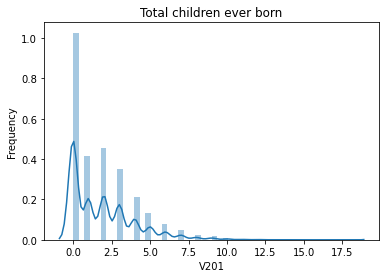

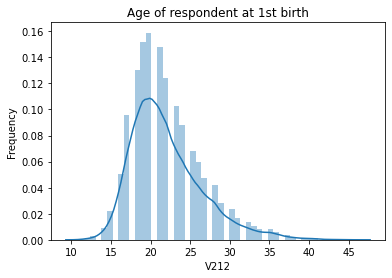

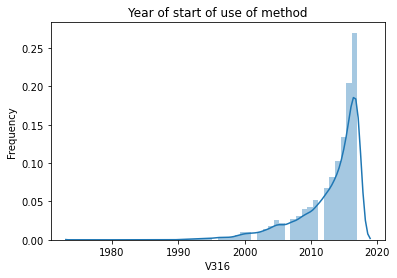

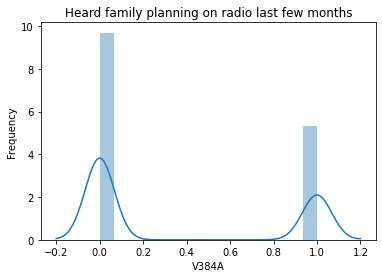

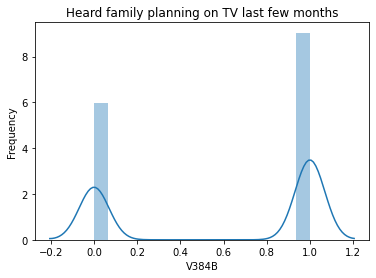

C:\Users\Patrisha Estrada\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


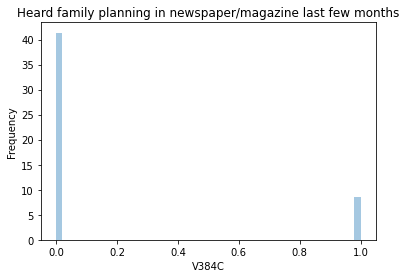

C:\Users\Patrisha Estrada\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


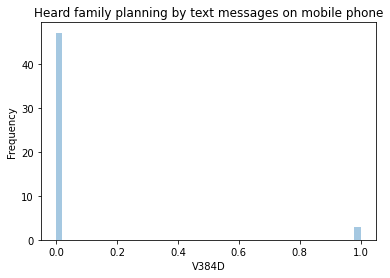

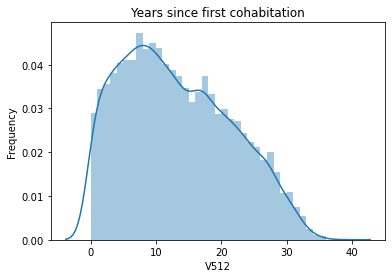

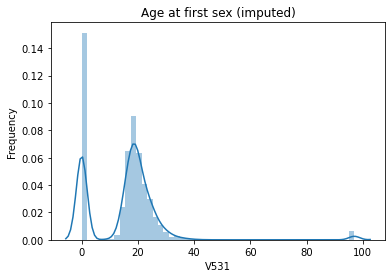

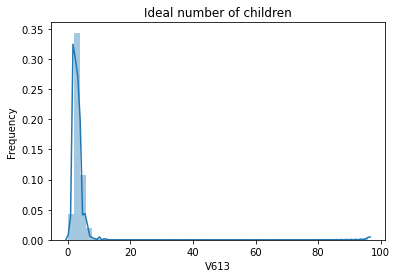

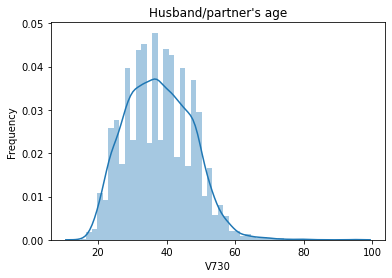

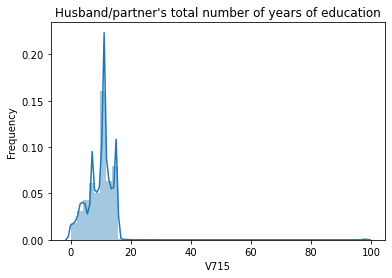

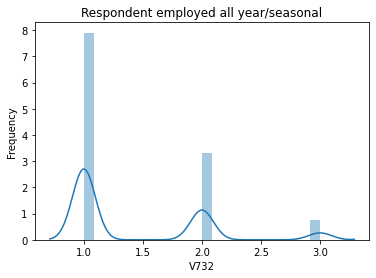

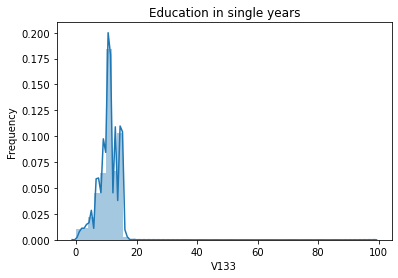

C:\Users\Patrisha Estrada\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


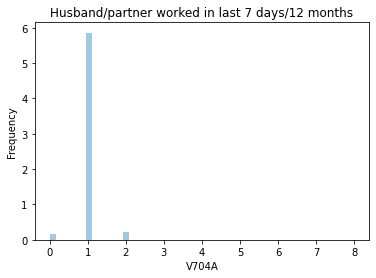

In [10]:
# Visualize histograms of each column
for col in df.columns:
    sns.distplot(df[col])
    plt.title(meta.column_names_to_labels[col])
    plt.ylabel('Frequency')
    plt.show()

## 3. Feature Engineering

A **feature** is structured data fed into a model which are usually in the form of columns in a table. The model algorithms require features with some specific characteristic to work properly. The "engineering" task involves:

- Preparing the input dataset to suit the format required by the machine learning algorithm.
- Improving the performance of machine learning models through conscious memory use.

Feature engineering includes the following.
1. **Handling Missing and Problematic values.** Do I have missing values? Should I remove or should I replace them? Are there values that seem to be off given the description of the feature? Are there duplicates? How should they be handled?
2. **Categorical features.** Categorical data represent types of data which may be divided into groups (e.g. colors, brands). Prior machine learning, it's important to transform them into machine-readable format. Set `Categorical` and `factorize` ordinal data, and use `OneHotEncoder` for nominal data
3. **Numerical features.** Numerical features can be ‘decoded’ into categorical features. The two most common ways to do this are *discretization* and *binarization*.
4. **Feature Scaling.** Scaling is a process where data is transformed using a function, i.e., a scaling, to a fixed range/ range with known distribution. *Standardization* and *Normalization* are some of the common feature scaling methods. 

Compare all of sklearn's feature scaling classes [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).

Let's start by renaming the current columns of the df (for convenience) and creating some of the columns that we want to use as features.

In [11]:
#Renaming columns for convenience
df = df.rename(columns={'V201': 'total_births',
'V212': 'age_1birth',
'V316': 'year_start_method',
'V384A': 'aware_famplan_radio',
'V384B': 'aware_famplan_tv',
'V384C': 'aware_famplan_prints',
'V384D': 'aware_famplan_mobile',
'V512': 'years_1cohabit',
'V531': 'age_1sex',
'V613': 'ideal_num_child',
'V730': 'partner_age',
'V715': 'partner_yrs_educ',
'V732': 'respo_work_allyr',
'V133': 'respo_yrs_educ',
'V704A': 'partner_work_p12m'
})

Let's look at the unique values of each column to know how to engineer them...

In [12]:
for col in df.columns:
    print(col, df[col].unique())
    print('-----'*10)

total_births [ 4.  0.  1.  2.  3.  7.  5.  6. 10.  8.  9. 12. 11. 13. 18. 14. 16. 15.]
--------------------------------------------------
age_1birth [21. nan 29. 23. 22. 17. 16. 24. 26. 18. 20. 25. 27. 19. 15. 34. 30. 38.
 28. 32. 14. 36. 40. 35. 33. 37. 12. 13. 31. 39. 11. 41. 43. 42. 46. 44.]
--------------------------------------------------
year_start_method [2015.   nan 2017. 2013. 2009. 2016. 2014. 2012. 1998. 2008. 2011. 2010.
 2000. 2004. 2002. 2005. 1999. 2007. 2003. 1996. 2006. 2001. 1995. 1992.
 1993. 1982. 1991. 1997. 1994. 1985. 1988. 1987. 1990. 1975.]
--------------------------------------------------
aware_famplan_radio [0. 1.]
--------------------------------------------------
aware_famplan_tv [1. 0.]
--------------------------------------------------
aware_famplan_prints [0. 1.]
--------------------------------------------------
aware_famplan_mobile [1. 0.]
--------------------------------------------------
years_1cohabit [10. nan  7. 32.  9. 18. 13.  6. 20.  2.  4. 2

In [13]:
# Derive years since started using method
df['years_since_method'] = df['year_start_method'].apply(lambda x: 2022 - x)

# Dropping original column since we don't need it
df = df.drop(columns='year_start_method')

In [14]:
# Replace non-numeric response for ideal_num_child with 0
df['ideal_num_child'] = df['ideal_num_child'].replace(96, 0)
df['ideal_num_child'].unique()

array([ 6.,  1.,  3.,  2.,  4.,  5.,  7.,  0., 10.,  8., 12., 11.,  9.,
       13., 15.])

In [15]:
# Replace inconsistent and don't know responses with the mean value of the column
df['age_1sex'] = df['age_1sex'].replace(97, np.mean(df[df['age_1sex']!=97]['age_1sex']))
df['partner_yrs_educ'] = df['partner_yrs_educ'].replace(98, np.mean(df[df['partner_yrs_educ']!=98]['partner_yrs_educ']))
df['respo_yrs_educ'] = df['respo_yrs_educ'].replace(98, np.mean(df[df['respo_yrs_educ']!=98]['respo_yrs_educ']))

In [16]:
# Binarize columns for respondent and her partner's work for the past year, 
df['respo_work_allyr'] = [1 if x == 1 else 0 for x in df['respo_work_allyr']]
df['partner_work_p12m'] = [1 if x == 2 else 0 for x in df['partner_work_p12m']]

Apart from the columns we've recoded, there are still null values that we haven't handled. Let's replace the nulls with zeroes since the nulls mean inapplicability of question/s to the respondent.

In [17]:
# Fill null values with 0
df = df.fillna(0)

Since our number values are on different scales, let's do feature scaling for the columns of our dataset.

In [18]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# for col in df.columns:
#     if col != 'total_births':
#         df[col] = scaler.fit_transform(df[[col]])

# df.head()

Visualize the distributions of the scaled features.

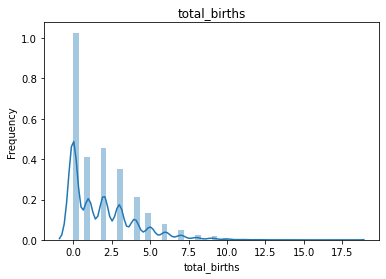

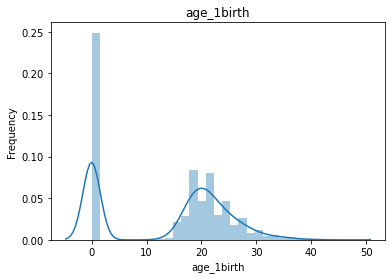

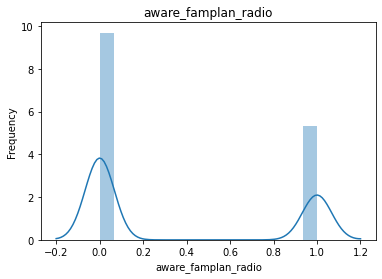

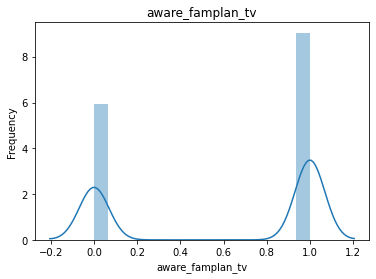

C:\Users\Patrisha Estrada\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


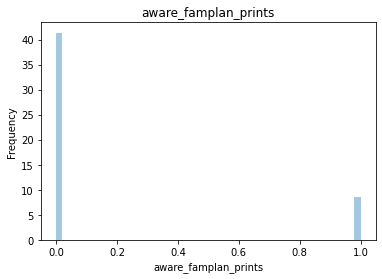

C:\Users\Patrisha Estrada\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


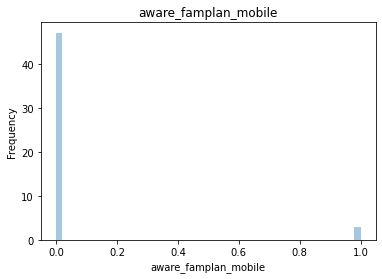

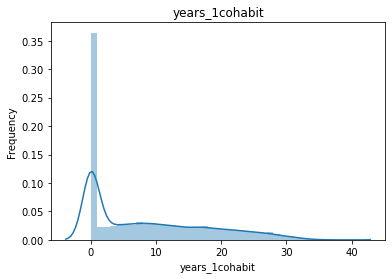

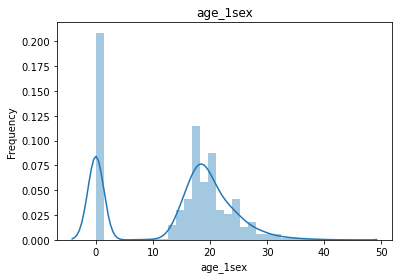

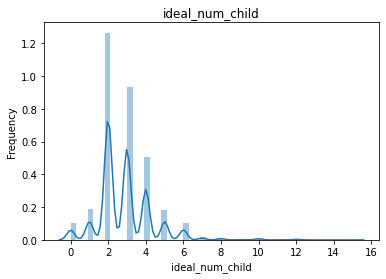

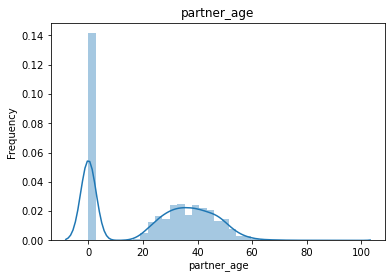

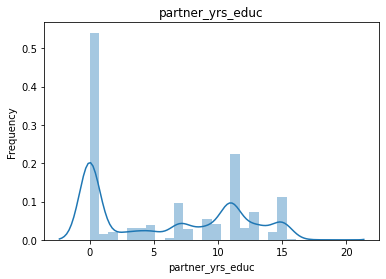

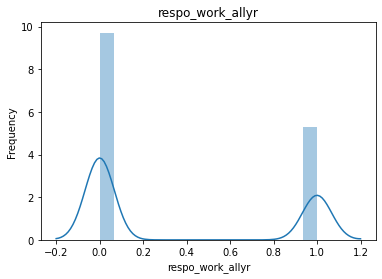

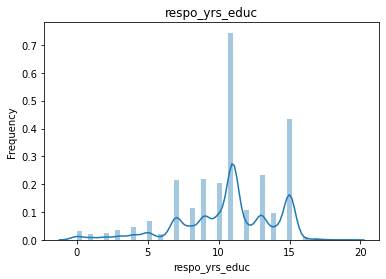

C:\Users\Patrisha Estrada\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


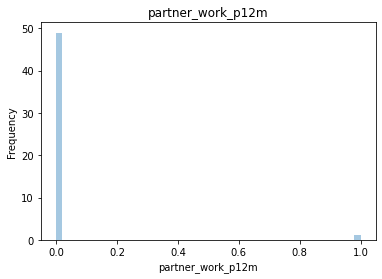

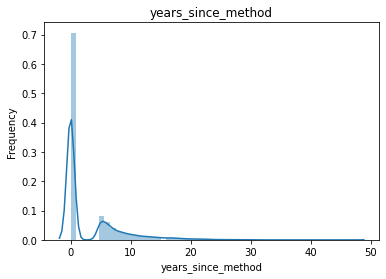

In [19]:
# Visualize histograms of each column
for col in df.columns:
    sns.distplot(df[col])
    plt.title(col)
    plt.ylabel('Frequency')
    plt.show()

## 4. Examine Features

Inspect the correlation matrix of your `df`.

In [20]:
df.corr()

,total_births,age_1birth,aware_famplan_radio,aware_famplan_tv,aware_famplan_prints,aware_famplan_mobile,years_1cohabit,age_1sex,ideal_num_child,partner_age,partner_yrs_educ,respo_work_allyr,respo_yrs_educ,partner_work_p12m,years_since_method
total_births,1.000000,0.583305,0.059622,-0.025691,-0.050684,-0.044976,0.765075,0.458275,0.432091,0.647554,0.347195,0.100553,-0.311097,0.039576,0.343775
age_1birth,0.583305,1.000000,0.104081,0.061473,0.027536,0.012962,0.592389,0.807969,0.233041,0.714761,0.636777,0.172878,-0.030133,0.084962,0.398963
aware_famplan_radio,0.059622,0.104081,1.000000,0.431136,0.368926,0.190256,0.077701,0.109346,0.005311,0.096713,0.105569,0.066997,0.069244,-0.003872,0.074470
aware_famplan_tv,-0.025691,0.061473,0.431136,1.000000,0.296127,0.171515,0.013746,0.080307,-0.044065,0.043565,0.129519,0.087814,0.215542,0.004183,0.060135
aware_famplan_prints,-0.050684,0.027536,0.368926,0.296127,1.000000,0.280328,-0.016742,0.048531,-0.034589,0.000299,0.079248,0.098404,0.190893,0.007603,0.020165
aware_famplan_mobile,-0.044976,0.012962,0.190256,0.171515,0.280328,1.000000,-0.034895,0.021617,-0.032418,-0.011657,0.050897,0.039922,0.109619,0.006456,-0.004159
years_1cohabit,0.765075,0.592389,0.077701,0.013746,-0.016742,-0.034895,1.000000,0.515917,0.353243,0.761531,0.438368,0.196105,-0.228622,0.057985,0.412633
age_1sex,0.458275,0.807969,0.109346,0.080307,0.048531,0.021617,0.515917,1.000000,0.195106,0.718145,0.681354,0.228817,0.038953,0.097670,0.337363
ideal_num_child,0.432091,0.233041,0.005311,-0.044065,-0.034589,-0.032418,0.353243,0.195106,1.000000,0.308155,0.136381,0.035627,-0.191955,0.007896,0.102064
partner_age,0.647554,0.714761,0.096713,0.043565,0.000299,-0.011657,0.761531,0.718145,0.308155,1.000000,0.767152,0.155146,-0.145178,0.106828,0.454738


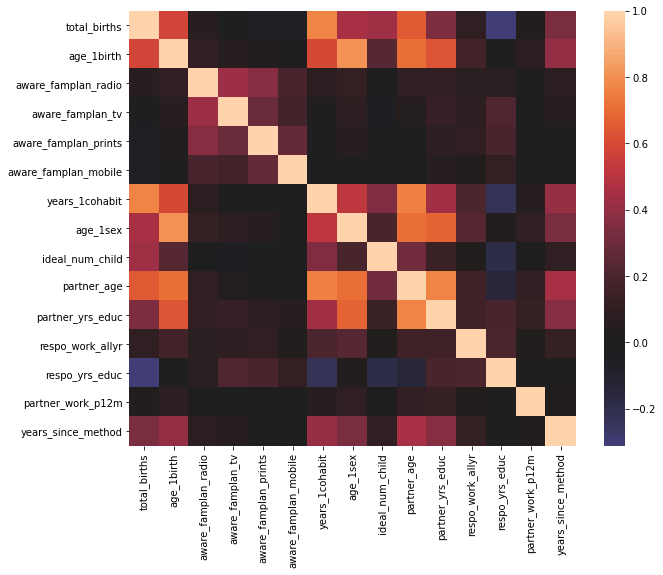

In [21]:
plt.figure(figsize=(10,8))

sns.heatmap(df.corr(), center=0.00)

plt.show()

## 5. Fit the Model

Do the following steps for each of your selected features:

a. Determine best fit line coefficients

In [22]:
from sklearn.linear_model import LinearRegression

feature_cols = ['years_1cohabit']
X = df[feature_cols]
y = df['total_births']

model = LinearRegression(fit_intercept=True)
model.fit(X,y)

print('Model intercept: %0.4f' % model.intercept_)
print('Model slope: %0.4f' % model.coef_[0])

Model intercept: 0.3744
Model slope: 0.1763


b. Obtain the R2 for the fit

In [23]:
print('Model R2: %0.4f' % model.score(X,y))

Model R2: 0.5853


In [24]:
# print expected y for different x values
for i in range(0,11):
    print(f'{i} years: {0.3744 + (0.1763*i)}')

0 years: 0.3744
1 years: 0.5507
2 years: 0.7270000000000001
3 years: 0.9033
4 years: 1.0796000000000001
5 years: 1.2559
6 years: 1.4322000000000001
7 years: 1.6085000000000003
8 years: 1.7848000000000002
9 years: 1.9611
10 years: 2.1374


Interpret the model coefficients. What does the R2 value tell you about the fitted model?

A unit increase in `years_1cohabit` will result to a 0.1763 increase in total births. In such case, on the first three to four years of cohabitation, there is an average of having one child based on the sample. Within three to seven years after birth of the first child, a second child may be born.  

Based on the R-squared, this may not be the best fit, so we hold back from this interpretation for now.

c. Compute for RMSE and MAE

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#define RMSE function
def RMSE(model, X, y):
    predicted = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predicted))
    return rmse
  
#define MAE function
def MAE(model, X, y):
    predicted = model.predict(X)
    mae = mean_absolute_error(y, predicted)
    return mae

In [26]:
print('Model RMSE: %0.4f' % RMSE(model,X,y))
print('Model MAE: %0.4f' % MAE(model,X,y))

Model RMSE: 1.3601
Model MAE: 0.9302


What does the RMSE and MAE tell you about the model performance?

The model's predicted total births is expected to be off by 1.3601 points (based on RMSE) or 0.9302 points (based on MAE) for the population covered.

d. Check for outliers and determine if removing them could result to a better fit

In [27]:
q1 = df['total_births'].quantile(0.25)
q3 =  df['total_births'].quantile(0.75)
IQR = q3 -q1

outliers = df[(df['total_births']<(q1-1.5*IQR)) | (df[ 'total_births']>(q3+1.5*IQR))]['total_births']
outliers

77       10.0
89       10.0
105       8.0
110      10.0
152      10.0
         ... 
24928     8.0
24948    12.0
25008     8.0
25011     9.0
25020    10.0
Name: total_births, Length: 524, dtype: float64

In [28]:
df = df[df['total_births'] != 178.37]

## 6. Using multiple features

Will using multiple features result into a better fit? Repeat the procedure in 5 and see if the metrics improve.
If it did improve, do you think its enough to make the model more credible?

In [29]:
# create X and y
feature_cols = ['years_1cohabit', 'age_1sex', 'ideal_num_child', 'partner_age', 'partner_yrs_educ', 'years_since_method']

X = df[feature_cols]
y = df['total_births']

lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print(lm.intercept_)
# pair the feature names with the coefficients
print(list(zip(feature_cols, lm.coef_)))

-0.40294502712877933
[('years_1cohabit', 0.12600833910833228), ('age_1sex', 0.015071714882000216), ('ideal_num_child', 0.25346512312090336), ('partner_age', 0.024646965079674538), ('partner_yrs_educ', -0.057296124644164344), ('years_since_method', 0.011641997699109575)]


In [30]:
# calculate the R-squared
lm.score(X, y)

0.6316363353011327

Model looks a bit better. Let's reinspect the relationship of the features we used for modelling to be sure that this figure is not bloated...

In [31]:
X.corr()

,years_1cohabit,age_1sex,ideal_num_child,partner_age,partner_yrs_educ,years_since_method
years_1cohabit,1.000000,0.515917,0.353243,0.761531,0.438368,0.412633
age_1sex,0.515917,1.000000,0.195106,0.718145,0.681354,0.337363
ideal_num_child,0.353243,0.195106,1.000000,0.308155,0.136381,0.102064
partner_age,0.761531,0.718145,0.308155,1.000000,0.767152,0.454738
partner_yrs_educ,0.438368,0.681354,0.136381,0.767152,1.000000,0.373626
years_since_method,0.412633,0.337363,0.102064,0.454738,0.373626,1.000000


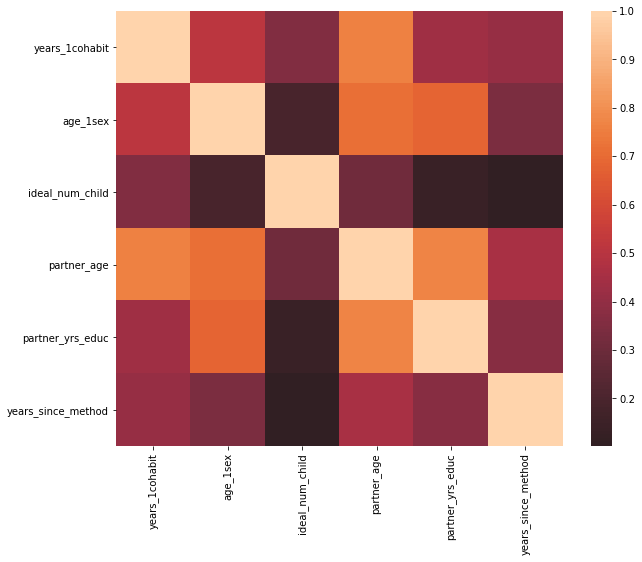

In [32]:
plt.figure(figsize=(10,8))

sns.heatmap(X.corr(), center=0.00)

plt.show()

Some of the features are highly correlated with each other. It could be why our R-squared went up a bit. How do we handle the highly correlated features?

In [33]:
X = X.drop(columns = ['partner_age', 'partner_yrs_educ'])
X.corr()

,years_1cohabit,age_1sex,ideal_num_child,years_since_method
years_1cohabit,1.000000,0.515917,0.353243,0.412633
age_1sex,0.515917,1.000000,0.195106,0.337363
ideal_num_child,0.353243,0.195106,1.000000,0.102064
years_since_method,0.412633,0.337363,0.102064,1.000000


Let's remake our model.

In [34]:
feature_cols = ['years_1cohabit', 'age_1sex', 'ideal_num_child', 'years_since_method']


X = df[feature_cols]
y = df['total_births']

lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print(lm.intercept_)
# pair the feature names with the coefficients
print(list(zip(feature_cols, lm.coef_)))

-0.4502559000326942
[('years_1cohabit', 0.14891345516895507), ('age_1sex', 0.01663751531231511), ('ideal_num_child', 0.27355947628860766), ('years_since_method', 0.013052152746367606)]


In [35]:
lm.score(X, y)

0.6211874080780011

From here we see how the highly correlated features did not affect the model scores so much. Based on this model's R-squared, what we know is that 62% of the data fits the regression model. Or that collectively, your X variables can explain 62% of the variance in y.

How do we move forward with this model? In further improving the model, it will help if we can also add more meaningful regressors. For now, let's also inspect the residuals so we know if there are other adjustments in the model that can be done. 

Text(0, 0.5, 'residual')

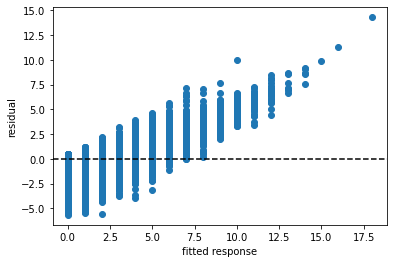

In [36]:
#compute residuals
residuals = y  - lm.predict(X)

plt.scatter(y, residuals)
plt.axhline(0,color='k',ls='--')
plt.xlabel('fitted response')
plt.ylabel('residual')

The errors are heteroskedastic. What does this mean?

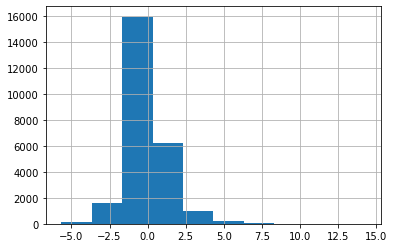

In [37]:
residuals.hist()

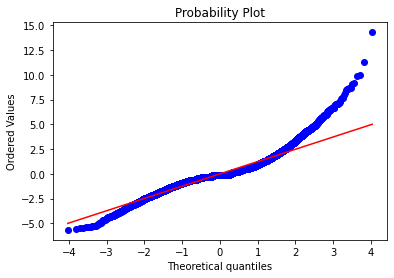

In [38]:
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

Here we see that there are a lot of extreme positive residuals. In the case that we’re making predictions, this error model is certainly important and will require further inspection of errors....

## 7. Using k-fold cross validation
We could further investigate on the models predictive performance using k-fold cross validation.
What does folding reveal about the linear model you built?

- For the model you built in (5), try the validation procedure for k=5 and k=10



In [39]:
X = X.to_numpy()
Y = y.to_numpy()

In [40]:
len(X)

25074

In [41]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    print(np.shape(X_train), np.shape(Y_train))
    print(np.shape(X_test), np.shape(Y_test))
    
    #fit using training data
    lin_model = LinearRegression()
    lin_model.fit(X_train, Y_train)
    
    #evaluate fit of train data
    print('train: R2=%0.2f '% lin_model.score(X_train, Y_train))

    #evaluate using test data
    print('test: RMSE=%0.2f, R2=%0.2f' % (RMSE(lin_model, X_test, Y_test), lin_model.score(X_test,Y_test)))

(20059, 4) (20059,)
(5015, 4) (5015,)
train: R2=0.61 
test: RMSE=1.41, R2=0.64
(20059, 4) (20059,)
(5015, 4) (5015,)
train: R2=0.62 
test: RMSE=1.15, R2=0.61
(20059, 4) (20059,)
(5015, 4) (5015,)
train: R2=0.62 
test: RMSE=1.24, R2=0.61
(20059, 4) (20059,)
(5015, 4) (5015,)
train: R2=0.62 
test: RMSE=1.35, R2=0.61
(20060, 4) (20060,)
(5014, 4) (5014,)
train: R2=0.63 
test: RMSE=1.37, R2=0.59
